In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime as dt

df = pd.read_csv('../data/jan_data.csv')
df['time'] = pd.to_datetime(df['time'])

df.iloc[1800]['dollar_open_interest_close']

df.tail(10)[['time','premium']]


C:\Users\vosko\AppData\Local\Temp\ipykernel_16412\43016817.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd
C:\Users\vosko\AppData\Local\Temp\ipykernel_16412\43016817.py:5: DtypeWarning: Columns (38) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('../data/jan_data.csv')


,time,premium
71001,2024-01-30 17:39:00,-0.711839
71002,2024-01-30 17:40:00,-0.593798
71003,2024-01-30 17:41:00,-0.940796
71004,2024-01-30 17:40:00,-0.593798
71005,2024-01-30 17:41:00,-0.940796
71006,2024-01-30 17:41:00,-0.940796
71007,2024-01-30 17:42:00,-0.799970
71008,2024-01-30 17:43:00,-0.689973
71009,2024-01-30 17:42:00,-0.799970
71010,2024-01-30 17:43:00,-0.689973


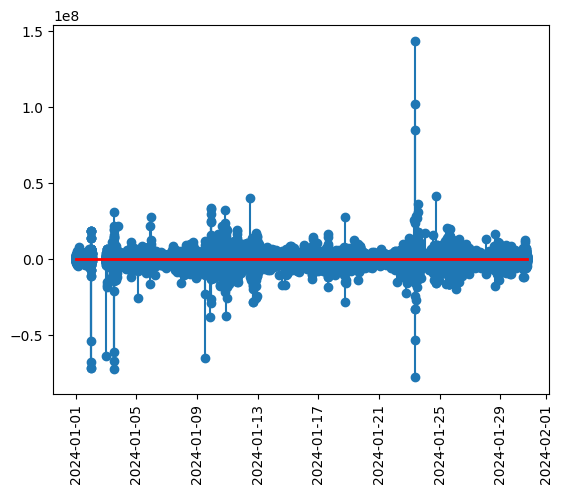

In [4]:

df['diff'] = df['dollar_open_interest_close'].diff()
df_jan2324 = df.loc[(df['time']>'2024-01-24')]
df_jan2324 = df
x = df_jan2324['time']
y = df_jan2324['diff']
plt.xticks(rotation=90)
markerline, stemlines, baseline  = plt.stem(x,y)
plt.setp(baseline, color='r', linewidth=2)

plt.show()


In [47]:
from scipy import stats
import math

df_slice = df_jan2324.loc[df_jan2324['search_resolution']==1]
df_slice = df_slice.sort_values(by='time')
df_slice = df_slice.drop_duplicates(subset=['time'])

window_size = 240
step = 120
start = 0
end = start + window_size
max_increase_tau = {'tau': 0, 'range_low':0, 'range_high':0, 'oi_difference':0}
max_decrease_tau = {'tau': 0, 'range_low':0, 'range_high':0, 'oi_difference':0}

# calcuate tau, calculate OI increase for those with positive tau, calculate funding and premium avg for the periods
rows = []
while end < len(df_slice):
    df_cut = df_slice.iloc[start:end]
    tau_oi = stats.kendalltau(df_cut.index, df_cut['dollar_open_interest_close'])
    tau_price = stats.kendalltau(df_cut.index, df_cut['close_price'])
    if tau_oi.statistic < 0:
        if max_decrease_tau['tau'] > tau_oi.statistic:
            max_decrease_tau = {'tau': tau_oi.statistic, 'range_low': start, 'range_high': end}
    else:
        # get mean premium for period
        premium = df_cut['premium'].mean()
        # get mean funding for period
        funding = df_cut['funding_rate'].mean()
        # OI increase
        oi_increase = df_cut.iloc[-1]['dollar_open_interest_close']-df_cut.iloc[1]['dollar_open_interest_close']
        # print(f"{oi_increase:,f} USD, {tau_oi.statistic}, 'Price Tau:' {tau_price.statistic} 'Avg funding:' {funding}, 'Avg premium:' {premium}, 'date_start': {df_slice.iloc[max_increase_tau['range_low']]['time']}, 'date_end': {df_slice.iloc[max_increase_tau['range_high']]['time']}")
        rows.append({"Start_Date": df_slice.iloc[max_increase_tau['range_low']]['time'], "End_Date": df_slice.iloc[max_increase_tau['range_high']]['time'], "TAU_OI": tau_oi.statistic, "TAU_Price": tau_price.statistic, "Funding": funding, "Premium": premium})
        max_increase_tau = {'tau': tau_oi.statistic, 'range_low': start, 'range_high': end}
    start += step
    end += step

df = pd.DataFrame(rows)
# identify ranges where price up, oi up + below 0.01 per 8 hr funding or neg premium
df_up = df.loc[(df['TAU_Price']>0.6) & (df['TAU_OI']>0.6) & ((df['Funding']<-0.0001) | (df['Premium']<0))]
# or price down, oi down + above 0.01 per 8hr funding or pos premium
df_down = df.loc[(df['TAU_Price']<-0.7) & (df['TAU_OI']<-0.7) & ((df['Funding']>0.0001) | (df['Premium']>0))]

df_up
# df_down

,Start_Date,End_Date,TAU_OI,TAU_Price,Funding,Premium
136,2024-01-25 03:00:00,2024-01-25 07:00:00,0.721897,0.714889,0.000100,-0.527532
149,2024-01-26 19:00:00,2024-01-26 23:00:00,0.823291,0.750536,0.000067,-0.864517
157,2024-01-28 11:00:00,2024-01-28 15:00:00,0.794561,0.706354,0.000100,-0.658780
